In [11]:
import pdb
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import PyQt6

matplotlib.rcParams.update({'font.size': 14,
                            'pdf.fonttype': 42,
                            'ps.fonttype': 42})
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

PATH_TO_FIXED_POINT_FINDER = '../../'
PATH_TO_HELPER = '../helper/'
sys.path.insert(0, PATH_TO_FIXED_POINT_FINDER)
sys.path.insert(0, PATH_TO_HELPER)

from FlipFlop import FlipFlop
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
from FlipFlopData import FlipFlopData
from plot_utils import plot_fps
from bayesRA import BayesRingRNN

from scipy.special import i0, i1
from scipy.optimize import root_scalar

def A_Bessel(kappa): 
    """Computes the ratio of Bessel functions."""
    r = i1(kappa)/i0(kappa)
    return r

def xi_fun_inv(dt):
    """Computes the inverse of the ratio of Bessel functions by root-finding."""
    f = lambda alpha: alpha * A_Bessel(alpha) - dt
    sol = root_scalar(f,bracket=[0.001,50],method='brentq')
    alpha = sol.root
    return alpha

def generate_data(batch_size=200):
	
	np.random.seed(42)
	T = 15
	dt = 0.01
	t = np.arange(0,T,dt)
	N = 80
	kappa_phi = 1 # inverse diffusion constant
	kappa_v = 2 # precision of relative heading info
	kappa_z = 15 # precision of absolute heading info (called gamma_z in manuscript)
	alpha = xi_fun_inv(kappa_z*dt) 

	### create kappa_z depending on environment. If light is off, kappa_z is zero (maximally uninformative)
	kappa_z_array = alpha * np.ones(int(T/dt)) # precision of absolute heading info

	trajectories = np.zeros((batch_size,len(t),N))
	true_HD = np.zeros((batch_size, len(t)))
	HD_obs = np.zeros((batch_size, len(t)))
	AV_obs = np.zeros((batch_size, len(t)))
	
	for batch in range(batch_size):
		### create hidden state trajectory and observation sequence
		phi = np.zeros(int(T/dt)) # latent state
		phi_0 = 0 
		kappa_0 = 10 # initial certainty
		phi[0] = np.random.vonmises(phi_0,kappa_0)
		phi[0] = (phi[0] + np.pi ) 
		dy = np.zeros(int(T/dt))
		for i in range(1,int(T/dt)):
				phi[i] = np.random.normal(phi[i-1],1/np.sqrt(kappa_phi) * np.sqrt(dt)) #True HD observations
				dy[i] = np.random.normal(phi[i]-phi[i-1],1/np.sqrt(kappa_v) * np.sqrt(dt)) #Angular velocity observations
		phi = (phi % (2*np.pi) ) - np.pi # convert true HD to circular coordinates
		mu_z = np.random.vonmises(phi,kappa_z_array) # draw HD observations from Von Mises distribution based on true HD

		phi_0_r = np.linspace(-np.pi,np.pi-(2*np.pi)/N,N)
		alpha = 100

		##### connectivity matrices
		W_rec_even = np.zeros((N,N))
		for i in range(N):
			for j in range(N):
				W_rec_even[i,j] = 2/N * np.cos(phi_0_r[i] - phi_0_r[j])
				
		W_rec_odd = np.zeros((N,N))
		for i in range(N):
			for j in range(N):
				W_rec_odd[i,j] = 2/N * np.sin(phi_0_r[i] - phi_0_r[j])
				
		M_inh = np.zeros((N,N))
		for i in range(N):
			for j in range(N):
				M_inh[i,j] =  (2/N)**2 * np.cos(phi_0_r[i] - phi_0_r[j])

		# set network parameters to match filtering
		alpha_tilde = 0
		alpha = alpha_tilde + 1/2 * kappa_v/kappa_phi * 1/(kappa_phi + kappa_v)
		W = ( (alpha_tilde + 1/(kappa_phi + kappa_v)) * W_rec_even 
			+ (kappa_v/(kappa_v+kappa_phi))*W_rec_odd * dy[0]/dt )
		M =  M_inh

		# init
		r = np.zeros((int(T/dt),N))
		r[0] = kappa_0 * np.cos(phi_0_r - phi_0)

		# run network filter
		for i in range(1,int(T/dt)):
			W =  ( (alpha_tilde + 1/(kappa_phi + kappa_v)) * W_rec_even 
			+ (kappa_v/(kappa_v+kappa_phi))*W_rec_odd * dy[i]/dt )
			r[i] = (r[i-1] 
					- alpha * r[i-1] * dt # decay
					- 1/(kappa_phi+kappa_v) * np.sqrt(np.dot(r[i-1],np.dot(M,r[i-1]))) * r[i-1] * dt # coincidence detector
					+ np.dot(W,r[i-1]) * dt # angular velocity integration
				+ kappa_z_array[i]*np.cos(phi_0_r-mu_z[i])) # absolute heading info (external input)
			
		trajectories[batch, :,:] = r
		true_HD[batch,:] = phi
		HD_obs[batch,:] = mu_z
		AV_obs[batch,:] = dy

	return trajectories, true_HD, HD_obs, AV_obs
	
def circplot(t,phi):
    """ Stiches t and phi to make unwrapped circular plot. """
    
    phi_minus = phi - 2*np.pi
    phi_plus = phi + 2*np.pi

    phi_array = np.array((phi_plus , phi , phi_minus))
    difference = np.abs(phi_array[:,1:] - phi[0:-1])
    ind_up = np.where(np.argmin(difference,axis=0)==0)[0]
    ind_down = np.where(np.argmin(difference,axis=0)==2)[0]
    ind = np.union1d(ind_up,ind_down)

    phi_stiched = np.copy(phi)
    t_stiched = np.copy(t)
    for i in np.flip(np.arange(ind.size)):
        idx = ind[i]
        if np.isin(idx,ind_up):
            phi_stiched = np.concatenate((phi_stiched[0:idx+1],[phi_plus[idx+1]],
                                          [np.nan],[phi_minus[idx]],phi_stiched[(idx+1):]))
        else:
            phi_stiched = np.concatenate((phi_stiched[0:idx+1],[phi_minus[idx+1]],
                                          [np.nan],[phi_plus[idx]],phi_stiched[(idx+1):]))
        t_stiched = np.concatenate((t_stiched[0:idx+2],[np.nan],t_stiched[idx:]))

    
    return t_stiched,phi_stiched


In [2]:
valid_predictions, true_HD, HD_obs, AV_obs = generate_data(batch_size=50)

In [3]:
check_traj = valid_predictions[0,:,:]

In [4]:
valid_predictions.shape

(50, 1500, 80)

In [5]:
inputs = np.stack((HD_obs, AV_obs), axis=2)
r0 = np.expand_dims(valid_predictions[:,0,:],axis=0)

print(inputs.shape)
print(r0.shape)

(50, 1500, 2)
(1, 50, 80)


In [6]:
inputs_single = inputs[:,0,:]

In [7]:
batch = 50

#rnn = BayesRingRNN(batch_size=1)
#input_single = torch.from_numpy(inputs[0,:,:]).unsqueeze(0)
#r0_single = torch.from_numpy(r0)[:,0,:].unsqueeze(1)
#print(input_single.size())
#print(r0_single.size())
#traj, r_t = rnn(torch.from_numpy(inputs[0,:,:]).unsqueeze(0), r0=torch.from_numpy(r0)[:,0,:].unsqueeze(1))

rnn = BayesRingRNN(batch_size=batch)
#traj, r_t = rnn(torch.from_numpy(inputs_single).unsqueeze(1), r0=torch.from_numpy(r0))
traj, r_t = rnn(torch.from_numpy(inputs), r0=torch.from_numpy(r0))

In [8]:
print(r_t[0,:,0])

tensor([ 8.1465, -0.7889,  7.1227,  0.3613,  4.3597, -4.7096,  7.4663,  4.5110,
        -3.0581,  4.3171, -6.8769, -6.6796, -1.0380, -7.4234,  7.7008, -3.0806,
         6.2656,  7.2979,  2.0456, -6.2458,  5.4834, -4.4560, -2.2604, -5.5717,
         5.0072, -7.7800,  6.1127,  5.2768,  9.3005, -6.1988, -5.6266,  1.7367,
        -4.5836,  2.9106, -7.0592, -6.3960,  6.7120,  5.4803,  8.9934,  2.0586,
        -5.8750, -5.9981, -4.4709, -6.4416, -7.1819,  6.7509,  0.6108, -4.2776,
         3.7590,  2.4741], dtype=torch.float64)


In [9]:
print(traj.shape)
print(valid_predictions.shape)

torch.Size([50, 1500, 80])
(50, 1500, 80)


In [10]:
print(inputs[0,150,1])
print(AV_obs[0,150])


-0.26507450095830554
-0.26507450095830554


In [11]:
print(valid_predictions.shape) #batch, time, neurons
print(true_HD.shape) #batch, time
print(HD_obs.shape) #batch, time
print(AV_obs.shape) #batch, time

(50, 1500, 80)
(50, 1500)
(50, 1500)
(50, 1500)


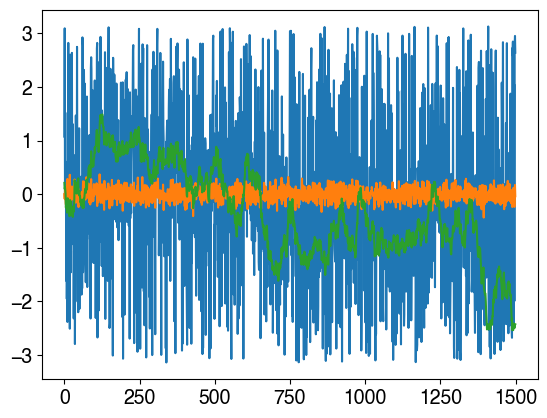

In [12]:
plt.plot(HD_obs[0,:])
plt.plot(AV_obs[0,:])
plt.plot(true_HD[0,:])

In [14]:
print(valid_predictions[1,:,0])
print(traj[1,:,0])

[-10.          -9.14033757  -9.44312465 ...   0.97996348  -0.39224302
  -0.78889175]
tensor([-10.0203,  -9.1118,  -9.4425,  ...,   0.9800,  -0.3922,  -0.7889],
       dtype=torch.float64)


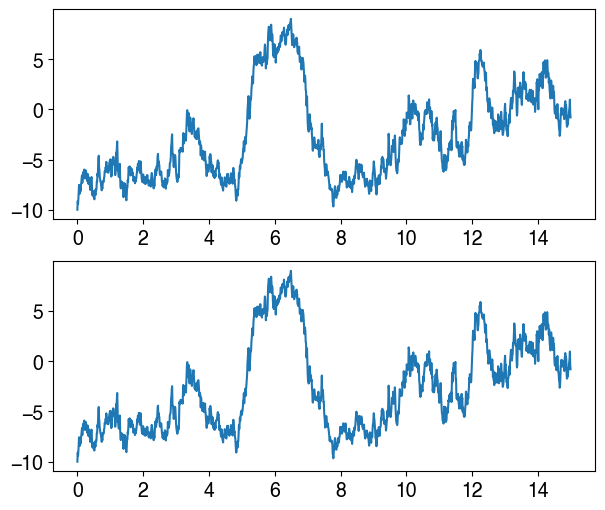

In [13]:
T = 15
dt = 0.01
t = np.arange(0,T,dt)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7,6))

ax1.plot(t, valid_predictions[1,:,0])
ax2.plot(t, traj[1,:,0])

#ax2.plot(t, traj[0,:])


ValueError: x and y must have same first dimension, but have shapes (1500,) and (50, 1500)

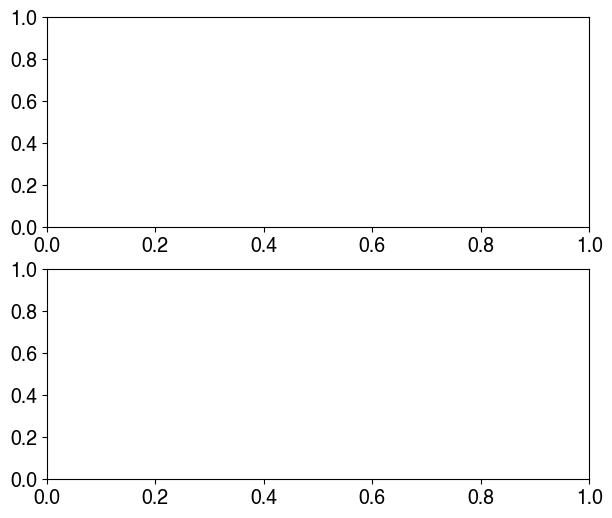

In [19]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7,6))



ax1.plot(*circplot(t,true_HD),linewidth=1,label=r'True HD $\varphi_t$',color='xkcd:teal')
ax1.plot(*circplot(t,mu_ProF),linewidth=1,color='xkcd:azure',label='circKF')
ax1.plot(*circplot(t,mu_NN),linewidth=1, label=r'Bayesian ring attractor',color='xkcd:bright purple')
ax1.set_xlim([0,T])
ax1.set_ylim([-np.pi,np.pi])
ax1.set_ylabel('HD estimate')
ax1.set_yticks([0., - np.pi, np.pi])
ax1.set_yticklabels(["$0$",r"$-\pi$",r"$\pi$"])
ax1.set_xticks([])
ax1.legend()

ax2.plot(t,kappa_ProF,linewidth=1,label=r'Precision $\kappa_t$',color='xkcd:azure')
ax2.plot(t,kappa_NN,linewidth=1, label=r'Network amplitude $\tilde{r}_1(t)$',color='xkcd:bright purple')
ax2.plot([t_on,t_on],[0,np.max(kappa_ProF)],linewidth=1,color='xkcd:salmon')
ax2.plot([t_off,t_off],[0,np.max(kappa_ProF)],linewidth=1,color='xkcd:salmon')
ax2.set_xlim([0,T])
ax2.set_xticks([])
ax2.set_ylim([0,np.max(kappa_ProF)])
ax2.set_ylabel(r'Certainty / Amplitude')

## Test Drosophila RNN

In [14]:
from drosophRNN import drosophRNN

def A_Bessel(kappa): 
    """Computes the ratio of Bessel functions."""
    r = i1(kappa)/i0(kappa)
    return r

def xi_fun_inv(dt):
    """Computes the inverse of the ratio of Bessel functions by root-finding."""
    f = lambda alpha: alpha * A_Bessel(alpha) - dt
    sol = root_scalar(f,bracket=[0.001,50],method='brentq')
    alpha = sol.root
    return alpha

def generate_data(T=5, dt=0.01,N=80, kappa_phi=1, kappa_v=2, kappa_z=15,batch_size=200):

	np.random.seed(42)
	
	t = np.arange(0,T,dt)
	alpha = xi_fun_inv(kappa_z*dt) 

	### create kappa_z depending on environment. If light is off, kappa_z is zero (maximally uninformative)
	kappa_z_array = alpha * np.ones(int(T/dt)) # precision of absolute heading info

	trajectories = np.zeros((batch_size,len(t),N))
	true_HD = np.zeros((batch_size, len(t)))
	HD_obs = np.zeros((batch_size, len(t)))
	AV_obs = np.zeros((batch_size, len(t)))
	
	for batch in range(batch_size):
		### create hidden state trajectory and observation sequence
		phi = np.zeros(int(T/dt)) # latent state
		phi_0 = 0 
		kappa_0 = 10 # initial certainty
		phi[0] = np.random.vonmises(phi_0,kappa_0)
		phi[0] = (phi[0] + np.pi ) 
		dy = np.zeros(int(T/dt))
		for i in range(1,int(T/dt)):
				phi[i] = np.random.normal(phi[i-1],1/np.sqrt(kappa_phi) * np.sqrt(dt)) #True HD observations
				dy[i] = np.random.normal(phi[i]-phi[i-1],1/np.sqrt(kappa_v) * np.sqrt(dt)) #Angular velocity observations
		phi = (phi % (2*np.pi) ) - np.pi # convert true HD to circular coordinates
		mu_z = np.random.vonmises(phi,kappa_z_array) # draw HD observations from Von Mises distribution based on true HD

		phi_0_r = np.linspace(-np.pi,np.pi-(2*np.pi)/N,N)
		alpha = 100

		##### connectivity matrices
		W_rec_even = np.zeros((N,N))
		for i in range(N):
			for j in range(N):
				W_rec_even[i,j] = 2/N * np.cos(phi_0_r[i] - phi_0_r[j])
				
		W_rec_odd = np.zeros((N,N))
		for i in range(N):
			for j in range(N):
				W_rec_odd[i,j] = 2/N * np.sin(phi_0_r[i] - phi_0_r[j])
				
		M_inh = np.zeros((N,N))
		for i in range(N):
			for j in range(N):
				M_inh[i,j] =  (2/N)**2 * np.cos(phi_0_r[i] - phi_0_r[j])

		# set network parameters to match filtering
		alpha_tilde = 0
		alpha = alpha_tilde + 1/2 * kappa_v/kappa_phi * 1/(kappa_phi + kappa_v)
		W = ( (alpha_tilde + 1/(kappa_phi + kappa_v)) * W_rec_even 
			+ (kappa_v/(kappa_v+kappa_phi))*W_rec_odd * dy[0]/dt )
		M =  M_inh

		# init
		r = np.zeros((int(T/dt),N))
		r[0] = kappa_0 * np.cos(phi_0_r - phi_0)

		# run network filter
		for i in range(1,int(T/dt)):
			W =  ( (alpha_tilde + 1/(kappa_phi + kappa_v)) * W_rec_even 
			+ (kappa_v/(kappa_v+kappa_phi))*W_rec_odd * dy[i]/dt )
			r[i] = (r[i-1] 
					- alpha * r[i-1] * dt # decay
					- 1/(kappa_phi+kappa_v) * np.sqrt(np.dot(r[i-1],np.dot(M,r[i-1]))) * r[i-1] * dt # coincidence detector
					+ np.dot(W,r[i-1]) * dt # angular velocity integration
				+ kappa_z_array[i]*np.cos(phi_0_r-mu_z[i])) # absolute heading info (external input)
			
		trajectories[batch, :,:] = r
		true_HD[batch,:] = phi
		HD_obs[batch,:] = mu_z
		AV_obs[batch,:] = dy

	return trajectories, true_HD, HD_obs, AV_obs

In [9]:
def get_mu_kappa(N_HD, r_HD):
    phi_0_HD = np.linspace(-np.pi,np.pi-(2*np.pi)/N_HD,N_HD)  # HD preferred angle

    # decode stochastic variables from HD population
    A_cos =  np.array([np.cos(phi_0_HD),np.sin(phi_0_HD)])
    theta = 2/N_HD * np.einsum('LN,btN->btL', A_cos, r_HD) # FT in Cartesian domain
    kappa = np.sqrt(np.sum(theta**2,axis=-1)) #convert to polar coordinates
    mu = np.arctan2(theta[...,1],theta[...,0])
    return mu, kappa

In [136]:
T = 20
dt = 0.001 
kappa_phi = 1 
kappa_y_v = 1
kappa_z = 15 
N=100

trajectories, true_HD, HD_obs, AV_obs = generate_data(T=T, dt=dt, N=N, kappa_phi=kappa_phi, kappa_v=kappa_y_v, kappa_z=15, batch_size=10)

mu_gen, kappa_gen = get_mu_kappa(N, trajectories)

In [5]:
print(trajectories.shape)

(10, 20000, 100)


In [6]:
print(mu_gen.shape)

(10, 20000)


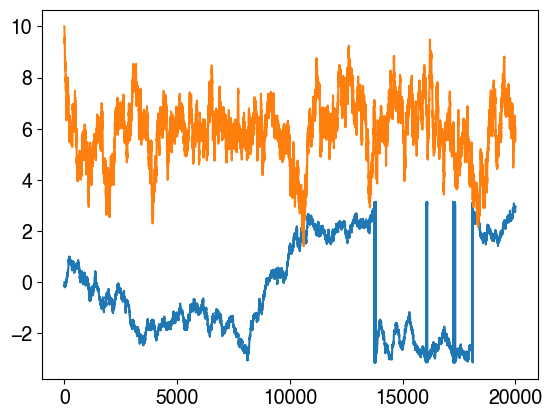

In [7]:
fig = plt.figure()

plt.plot(mu_gen[0,:])
plt.plot(kappa_gen[0,:])

plt.show()

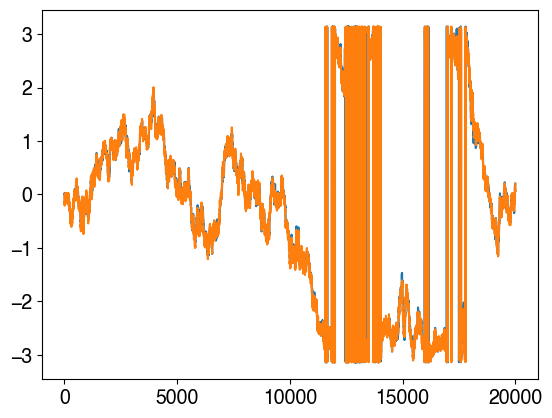

In [13]:
fig = plt.figure()

plt.plot(mu_net[5,:])
plt.plot(mu_gen[5,:])

plt.show()

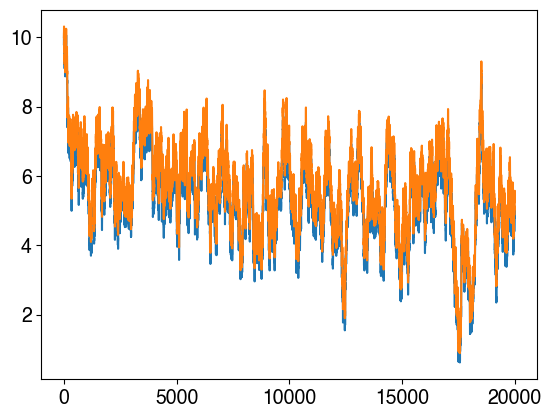

In [12]:
fig = plt.figure()

plt.plot(kappa_net[5,:])
plt.plot(kappa_gen[5,:])

plt.show()

In [11]:
def fact(x):

	return torch.functional.relu(x)

In [187]:
rnn = drosophRNN(dt=dt, kappa_phi =kappa_phi, kappa_y=kappa_y_v)

inputs = torch.from_numpy(np.stack((HD_obs, AV_obs), axis=2))
initial_r_HD = torch.from_numpy(trajectories[:,0,:])

initial_r_AVplus = rnn.w_AVplus_HD * torch.einsum('ij,bj->bi', rnn.W_AVplus_HD, initial_r_HD)
initial_r_AVminus = rnn.w_AVplus_HD * torch.einsum('ij,bj->bi', rnn.W_AVminus_HD, initial_r_HD)

initial_r_Del7 = 2 * rnn.w0 * rnn.kappa_0/(np.pi*(1-2*rnn.m0)) + rnn.w1 * rnn.kappa_0/(2*(1-rnn.m1))*torch.cos(rnn.phi_0_r_Del7-rnn.phi_0)
initial_r_Del7 = initial_r_Del7.unsqueeze(0).repeat(initial_r_HD.shape[0],1)

initial_state = torch.cat((initial_r_HD, initial_r_AVplus, initial_r_AVminus, initial_r_Del7), axis=1)

initial_state = initial_state.unsqueeze(0)

r_full, r_final = rnn(inputs, initial_state)

#r_full should be bxtxd
r_HD_net = r_full[:,:,:N]

mu_net, kappa_net = get_mu_kappa(N, r_HD_net)

In [2]:
import numpy as np

x = np.arange(4)
y = 3* np.ones(4)

print(x*y)

[0. 3. 6. 9.]


In [174]:
rnn.W_HD_HD

tensor([[0.0360, 0.0359, 0.0357,  ..., 0.0353, 0.0357, 0.0359],
        [0.0359, 0.0360, 0.0359,  ..., 0.0347, 0.0353, 0.0357],
        [0.0357, 0.0359, 0.0360,  ..., 0.0340, 0.0347, 0.0353],
        ...,
        [0.0353, 0.0347, 0.0340,  ..., 0.0360, 0.0359, 0.0357],
        [0.0357, 0.0353, 0.0347,  ..., 0.0359, 0.0360, 0.0359],
        [0.0359, 0.0357, 0.0353,  ..., 0.0357, 0.0359, 0.0360]],
       dtype=torch.float64)

In [180]:
print(rnn.alpha)

0.17353034752595942


In [179]:
import pickle
import scipy.io as sio

params = {
    "W_HD_HD" : rnn.W_HD_HD.numpy(),
    "W_HD_AVplus" : rnn.W_HD_AVplus.numpy(),
    "W_HD_AVminus" : rnn.W_HD_AVminus.numpy(),
    "W_AVplus_HD" : rnn.W_AVplus_HD.numpy(),
    "W_AVminus_HD" : rnn.W_AVminus_HD.numpy(),
    "W_Del7_HD" : rnn.W_Del7_HD.numpy(),
    "W_Del7_Del7" : rnn.W_Del7_Del7.numpy(),
    "W_HD_Del7" : rnn.W_HD_Del7.numpy(),
    "phi_0_r_HD": rnn.phi_0_r_HD.numpy(),
    "phi_0_r_Del7": rnn.phi_0_r_Del7.numpy(),
    "alpha": rnn.alpha
}

with open('/Users/dysprague/fixed-point-finder/data/fly_RNN_params.pkl','wb') as f:
    pickle.dump(params, f, pickle.HIGHEST_PROTOCOL)

with open('/Users/dysprague/fixed-point-finder/data/fly_RNN_params.pkl','rb') as f:
    params = pickle.load(f)
    sio.savemat('/Users/dysprague/fixed-point-finder/data/fly_RNN_params.mat', params)


In [160]:
r_AV_net.shape

torch.Size([100, 20000, 100])

In [167]:
r_use = r_full.numpy()

r_AV_net = r_use[:,:,100:200]

r_AV_range = np.max(r_AV_net, axis=2) - np.min(r_AV_net, axis=2)

q_diff = np.diff(r_use, axis=1)
q_b = 0.5*np.sum(np.square(q_diff),axis=2)


In [169]:
fig, axs = plt.subplots(4,1, sharex=True)

for b in range(r_full.shape[0]):

    axs[0].plot(mu_net[b,:])
    axs[1].plot(kappa_net[b,:])
    axs[2].plot(q_b[b,:])
    axs[3].plot(r_AV_range[b,:])

plt.show()
    

In [20]:
print(np.sum(trajectories-r_full[:,:,:100].numpy()))

-26255400.72955815


In [17]:
trajectories.shape

(10, 20000, 100)

In [18]:
r_full.shape

torch.Size([10, 20000, 300])

## Test Drosophila RNN with different inputs to estimate steady state values

In [88]:
HD_obs.shape

(10, 20000)

In [95]:
rnn = drosophRNN(dt=dt, kappa_phi =kappa_phi, kappa_y=kappa_y_v)

HD_input = 0
HD_obs_test = np.ones((HD_obs.shape[0],1000))*HD_input

AV_input = 0
AV_obs_test = np.ones((AV_obs.shape[0],1000))*AV_input

inputs = torch.from_numpy(np.stack((HD_obs, AV_obs), axis=2))
inputs_test = torch.from_numpy(np.stack((HD_obs_test, AV_obs_test), axis=2))

sample_indices = np.random.randint(inputs_test.shape[1], size=inputs_test.shape[0])

state_samples = np.zeros((sample_indices.shape[0], trajectories.shape[2]))
for i, sample in enumerate(sample_indices):
    state_samples[i,:] = trajectories[i, sample, :] 

#initial_r_HD = torch.from_numpy(trajectories[:,0,:])

initial_r_HD = torch.from_numpy(state_samples)

initial_r_AVplus = rnn.w_AVplus_HD * torch.einsum('ij,bj->bi', rnn.W_AVplus_HD, initial_r_HD)
initial_r_AVminus = rnn.w_AVplus_HD * torch.einsum('ij,bj->bi', rnn.W_AVminus_HD, initial_r_HD)

initial_r_Del7 = 2 * rnn.w0 * rnn.kappa_0/(np.pi*(1-2*rnn.m0)) + rnn.w1 * rnn.kappa_0/(2*(1-rnn.m1))*torch.cos(rnn.phi_0_r_Del7-rnn.phi_0)
initial_r_Del7 = initial_r_Del7.unsqueeze(0).repeat(initial_r_HD.shape[0],1)

initial_state = torch.cat((initial_r_HD, initial_r_AVplus, initial_r_AVminus, initial_r_Del7), axis=1)

initial_state = initial_state.unsqueeze(0) 
initial_state_rand = torch.from_numpy(np.random.normal(scale=20., size=initial_state.shape))

r_full_test, r_final = rnn(inputs_test, initial_state_rand)

#r_full should be bxtxd
r_HD_net = r_full_test[:,:,:N]

mu_net, kappa_net = get_mu_kappa(N, r_HD_net)

In [91]:
r_HD_net.shape

torch.Size([10, 1000, 100])

In [104]:
r_full_test.shape

torch.Size([10, 1000, 300])

In [109]:
x = np.mean(r_full_test.numpy()[:,13,:100], axis=1)
print(kappa_net[:,13])

print(x)



[4.60978268 0.2400115  2.17177012 3.10728971 5.8116832  5.53387009
 2.16919519 4.16019362 0.11450011 3.18390432]
[ 1.47632647 -0.27497677  2.11566736 -0.70737431 -0.83449334  0.84384893
 -3.72225409  1.1062163   0.39087282 -0.70346511]


In [102]:
fig, axs = plt.subplots(4,1)

for i in range(mu_net.shape[0]):
    axs[0].plot(mu_net[i,:])
    axs[1].plot(kappa_net[i,:])

    axs[2].plot(r_full_test[i,13,:])
    #axs[2].plot(initial_state_rand[0,i,:])
    axs[3].plot(r_full_test[i,15,:])

plt.show()

In [76]:
def IdMatr(x_to,x_from,sig=0.001):
	N_to = x_to.size
	N_from = x_from.size
	IdM = np.zeros((N_to,N_from))
	for i in range(N_to):
		for j in range(N_from):
			dist = np.arccos(np.cos(x_to[i]-x_from[j]))
			IdM[i,j] = (1/(np.sqrt(2*np.pi)*sig)
							* np.exp(-(1/2)*(dist**2/sig**2 ) ) )
	IdM = IdM/np.sum(IdM,1)[0]  # normalize
	return IdM

In [77]:
def get_mu_kappa_singlet(N_HD, r_HD):
    phi_0_HD = np.linspace(-np.pi,np.pi-(2*np.pi)/N_HD,N_HD)  # HD preferred angle

    # decode stochastic variables from HD population
    A_cos =  np.array([np.cos(phi_0_HD),np.sin(phi_0_HD)])
    theta = 2/N_HD * np.einsum('LN,bN->bL', A_cos, r_HD) # FT in Cartesian domain
    kappa = np.sqrt(np.sum(theta**2,axis=-1)) #convert to polar coordinates
    mu = np.arctan2(theta[...,1],theta[...,0])
    return mu, kappa

In [78]:
mu_init, kappa_init = get_mu_kappa_singlet(state_samples.shape[1], state_samples) # mu_unit = batch x 1

HD_samples = mu_init + np.random.uniform(-np.pi/4, np.pi/4, len(mu_init))
HD_samples = np.stack([HD_samples for _ in range(inputs_test.shape[1])], axis=1)


In [137]:
HD_samples.shape

(100, 1000)

In [130]:
inputs_test.shape

torch.Size([100, 1000, 2])

In [143]:
mu_init, kappa_init = get_mu_kappa_singlet(state_samples.shape[1], state_samples) # mu_unit = batch x 1

HD_samples = mu_init + np.random.uniform(-np.pi/4, np.pi/4, len(mu_init))
HD_samples = np.stack([HD_samples for _ in range(inputs_test.shape[1])], axis=1)

inputs_test[:,:,0] = torch.from_numpy(HD_samples)

r_full_same_side, r_final_same_side = rnn(inputs_test, initial_state)

r_HD_net_same = r_full_same_side[:,:,:N]

mu_net_sameside, kappa_net_sameside = get_mu_kappa(N, r_HD_net_same)

In [145]:
r_HD_net_same = r_full_same_side[:,:,:N]
mu_net_sameside, kappa_net_sameside = get_mu_kappa(N, r_HD_net_same)

In [146]:
mu_init, kappa_init = get_mu_kappa_singlet(state_samples.shape[1], state_samples) # mu_unit = batch x 1

HD_samples = mu_init + np.random.uniform(-np.pi/4+np.pi, np.pi/4+np.pi, len(mu_init))
HD_samples = np.stack([HD_samples for _ in range(inputs_test.shape[1])], axis=1)

inputs_test[:,:,0] = torch.from_numpy(HD_samples)

r_full_diff_side, r_final_diff_side = rnn(inputs_test, initial_state)

r_HD_net_diff = r_full_diff_side[:,:,:N]

mu_net_diffside, kappa_net_diffside = get_mu_kappa(N, r_HD_net_diff)

In [79]:
def check_decreasing(array):

    for i in range(1,len(array)):
        if array[i-1]<array[i]:
            return False
        
    return True

def plot_sim_test(mu_net, kappa_net, r_full_test):
    fig,axs = plt.subplots(3,2, sharex=True)

    r_full_numpy = r_full_test.numpy()

    dt_diff = r_full_numpy[:,1:,:]-r_full_numpy[:,:-1,:]
    q_b = 0.5*np.sum(np.square(dt_diff),axis=2)

    decrease =0 
    increase = 0

    for b in range(r_full_test.shape[0]):

        if check_decreasing(q_b[b,:]):

            min_tp = np.argmin(kappa_net[b,:])
            r_min = r_full_test[b,min_tp,:]

            axs[0,0].plot(mu_net[b,:])
            axs[1,0].plot(kappa_net[b,:])
            axs[2,0].plot(q_b[b,:])
            #axs[3,0].plot(r_min)
            decrease +=1

        elif not check_decreasing(q_b[b,:]):
            min_tp = np.argmin(kappa_net[b,:])
            r_min = r_full_test[b,min_tp,:]

            axs[0,1].plot(mu_net[b,:])
            axs[1,1].plot(kappa_net[b,:])
            axs[2,1].plot(q_b[b,:])
            #axs[3,1].plot(r_min)

            print(mu_net[b,min_tp])

            increase +=1

    plt.xlim([0,40])
    plt.show()

    print(decrease)
    print(increase)

In [151]:
plot_sim_test(mu_net_sameside, kappa_net_sameside, r_full_same_side)

100
0


In [152]:
plot_sim_test(mu_net_diffside, kappa_net_diffside, r_full_diff_side)

-0.5248764724271993
-1.8550526324762706
1.5785989411966141
-0.6512289096951636
1.283989401960729
-1.1926446908374542
0.5102785394467356
-1.351574092614486
-0.599610789307323
-1.9252130666096452
1.831819747038528
-1.2000152995645093
1.3205247718514013
-1.2085274733248317
-1.1224713349986526
0.3266511968993355
-0.693372945127477
0.03526777198972459
1.3491232088069813
0.551705414679253
1.0837440539557308
1.889735194861241
-1.8502820756228473
0.2914359240817177
-0.5931221182406214
1.369315860316316
2.2213059381755436
-1.0346177192582438
0.7622607755716848
-2.0131323073770107
2.6335431639810336
1.1198645648984176
0.4008542179230894
-1.8645665872892914
-0.5333362704500284
-1.1037506714878855
0.9857778201181365
-0.4841477752307195
-1.1939530831647855
-0.8268301323277254
1.5527583373988085
-1.2447052374319199
-0.29884295471792144
0.18152980465808594
2.2920481586220456
1.639199139574539
1.1224463373824325
2.8014140195489263
1.4862708305292167
0.9968748814161524
0.23360012026877786
-2.4260345554

In [ ]:
fig,axs = plt.subplots(4,2, sharex=True)

r_full_numpy = r_full_test.numpy()

dt_diff = r_full_numpy[:,1:,:]-r_full_numpy[:,:-1,:]
q_b = 0.5*np.sum(np.square(dt_diff),axis=2)

decrease =0 
increase = 0

for b in range(r_HD_net.shape[0]):

    if check_decreasing(q_b[b,:]):

        min_tp = np.argmin(kappa_net[b,:])
        r_min = r_full_test[b,min_tp,:]

        axs[0,0].plot(mu_net[b,:])
        axs[1,0].plot(kappa_net[b,:])
        axs[2,0].plot(q_b[b,:])
        axs[3,0].plot(r_min)
        decrease +=1

    elif not check_decreasing(q_b[b,:]):
        min_tp = np.argmin(kappa_net[b,:])
        r_min = r_full_test[b,min_tp,:]

        axs[0,1].plot(mu_net[b,:])
        axs[1,1].plot(kappa_net[b,:])
        axs[2,1].plot(q_b[b,:])
        axs[3,1].plot(r_min)

        print(mu_net[b,min_tp])

        increase +=1

plt.xlim([0,40])
plt.show()

print(decrease)
print(increase)

In [96]:
state_samples.shape

(100, 100)

In [98]:
q_b.shape

(100, 999)

In [101]:
print(r_full_test.shape)

torch.Size([100, 1000, 300])


In [121]:
fig,axs = plt.subplots(4,2, sharex=True)

r_full_numpy = r_full_test.numpy()

dt_diff = r_full_numpy[:,1:,:]-r_full_numpy[:,:-1,:]
q_b = 0.5*np.sum(np.square(dt_diff),axis=2)

decrease =0 
increase = 0

for b in range(r_HD_net.shape[0]):

    if check_decreasing(q_b[b,:]):

        min_tp = np.argmin(kappa_net[b,:])
        r_min = r_full_test[b,min_tp,:]

        axs[0,0].plot(mu_net[b,:])
        axs[1,0].plot(kappa_net[b,:])
        axs[2,0].plot(q_b[b,:])
        axs[3,0].plot(r_min)
        decrease +=1

    elif not check_decreasing(q_b[b,:]):
        min_tp = np.argmin(kappa_net[b,:])
        r_min = r_full_test[b,min_tp,:]

        axs[0,1].plot(mu_net[b,:])
        axs[1,1].plot(kappa_net[b,:])
        axs[2,1].plot(q_b[b,:])
        axs[3,1].plot(r_min)

        print(mu_net[b,min_tp])

        increase +=1

plt.xlim([0,40])
plt.show()

print(decrease)
print(increase)

1.5131114376072905
1.5264328617038596
-1.4863297680530259
97
3


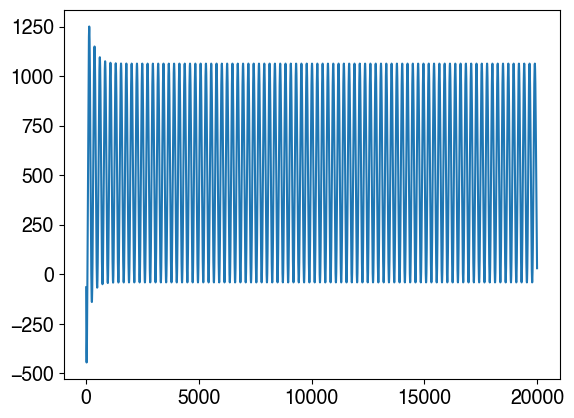

In [66]:
fig = plt.figure()


AV_trace = r_full[0, :, 100]



plt.plot(AV_trace)

plt.show()

## Data analysis

In [168]:
%matplotlib qt 

fps = np.load('/Users/dysprague/fixed-point-finder/data/fly_HD_varied_0_AV.npy')

row_max = np.max(fps, axis=1)
mask = row_max < 5

thresh_fps = fps[mask,:]

fig = plt.figure()

for fp in range(thresh_fps.shape[0]):
    plt.plot(thresh_fps[fp,:])

plt.show()


In [16]:
initial_state.shape

torch.Size([1, 19, 300])

In [119]:
import sklearn

In [169]:
rnn = drosophRNN(dt=dt, kappa_phi =kappa_phi, kappa_y=kappa_y_v)

thresh_fps_test = thresh_fps
thresh_fps_test[:,:100] = thresh_fps_test[:,:100]/2

initial_state = torch.from_numpy(thresh_fps_test)

initial_state = initial_state.unsqueeze(0)

inputs = torch.from_numpy(np.zeros((initial_state.shape[1],5000,2)))
inputs[:,:,0] = torch.from_numpy((np.pi/2)*np.ones((initial_state.shape[1],5000)))

r_full, r_final = rnn(inputs, initial_state)

#r_full should be bxtxd
r_HD_net_thresh_fps = r_full[:,:,:N]

mu_net_thresh_fps, kappa_net_thresh_fps = get_mu_kappa(N, r_HD_net_thresh_fps)

In [156]:
mu_fps, kappa_fps = get_mu_kappa_singlet(100, thresh_fps[:,:100])

In [170]:
fig, axs = plt.subplots(2,1)

for i in range(r_HD_net_thresh_fps.shape[0]):
    axs[0].plot(r_HD_net_thresh_fps[i,0,:])
    axs[1].plot(r_HD_net_thresh_fps[i,-1,:])

plt.show()

In [122]:
thresh_fps.shape

(19, 300)

In [125]:
print(kappa_fps)
r0HD_thresh = np.zeros(thresh_fps.shape[0])
for i in range(thresh_fps.shape[0]):
    fp = thresh_fps[i,:100]
    r0HD[i] = sklearn.metrics.auc(np.linspace(-np.pi,np.pi-(2*np.pi)/100,100),fp)/np.pi


[0.38908896 0.39162316 0.37571654 0.4050435  0.43153904 0.38044149
 0.38752381 0.37254977 0.37555479 0.39689524 0.50351309 0.41987622
 0.39203833 0.3957918  0.38911004 0.41735427 0.40040666 0.39178706
 0.37793972]


In [126]:
fig = plt.figure()
plt.scatter(kappa_fps, r0HD)

plt.show()

In [112]:
print(r_HD_net.shape)
print(thresh_fps.shape)

torch.Size([19, 5000, 100])
(19, 300)


In [26]:
fig,axs = plt.subplots(3,1)

for b in range(r_HD_net.shape[0]):

    axs[0].plot(mu_net[b,:,])
    axs[1].plot(kappa_net[b,:,])
    axs[2].plot(r_full[b,-130,:])

plt.show()


In [127]:
loaded_data = np.load('/Users/dysprague/fixed-point-finder/data/fly_HD_varied_0_AV_fps.npz')

inits = loaded_data['inits']
fstar = loaded_data['fstar']
q_b = loaded_data['q_b']

In [225]:
loaded_data = np.load('/Users/dysprague/fixed-point-finder/data/fly_HD_pi2_AV_001.npz')

inits = loaded_data['inits'] 
fstar = loaded_data['fstar']
q_b = loaded_data['q_b']

In [230]:
loaded_data = np.load('/Users/dysprague/fixed-point-finder/data/fly_HD_removed_001_AV.npz')

inits = loaded_data['inits'] 
fstar = loaded_data['fstar']
q_b = loaded_data['q_b']

In [235]:
loaded_data = np.load('/Users/dysprague/fixed-point-finder/data/fly_HD_removed_0_AV.npz')

inits = loaded_data['inits'] 
fstar = loaded_data['fstar']
q_b = loaded_data['q_b']

In [293]:
loaded_data = np.load('/Users/dysprague/fixed-point-finder/data/fly_HD_varied_AV_varied.npz')

inits = loaded_data['inits'] 
fstar = loaded_data['fstar']
q_b = loaded_data['q_b']

In [294]:
fig = plt.figure()

plt.plot(q_b)

plt.show()

In [307]:
thresh_idxs = q_b>0.02
thresh_inits = inits[thresh_idxs,:]
thresh_fstar = fstar[thresh_idxs,:]

In [308]:
unthresh_idxs = q_b <=0.02
unthresh_inits = inits[unthresh_idxs,:]
unthresh_fstar = fstar[unthresh_idxs,:]

In [303]:
print(kappa_net.shape)
print(r_HD_net.shape)
r_HD_net = r_HD_net.numpy()

(10, 20000)
(10, 20000, 100)


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [309]:
r0_AUC_traj = np.zeros(kappa_net.shape)

for i in range(trajectories.shape[0]):
    for j in range(trajectories.shape[1]):
        r0_AUC_traj[i,j] = sklearn.metrics.auc(np.linspace(-np.pi,np.pi-(2*np.pi)/100,100),r_HD_net[i,j,:])/np.pi


In [310]:
mu_fps_thresh, kappa_fps_thresh = get_mu_kappa_singlet(100, thresh_fstar[:,:100])

r0HD_thresh = np.zeros(thresh_fstar.shape[0])

for i in range(thresh_fstar.shape[0]):
    fp = thresh_fstar[i,:100]
    r0HD_thresh[i] = sklearn.metrics.auc(np.linspace(-np.pi,np.pi-(2*np.pi)/100,100),fp)/np.pi

mu_fps_unthresh, kappa_fps_unthresh = get_mu_kappa_singlet(100, unthresh_fstar[:,:100])
r0HD_unthresh = np.zeros(unthresh_fstar.shape[0])

for i in range(unthresh_fstar.shape[0]):
    fp = unthresh_fstar[i,:100]
    r0HD_unthresh[i] = sklearn.metrics.auc(np.linspace(-np.pi,np.pi-(2*np.pi)/100,100),fp)/np.pi


In [312]:
fig = plt.figure()
x = np.arange(22)-2
y = np.arange(22)-2

plt.scatter(kappa_fps_unthresh, np.abs(r0HD_unthresh), label='Stable fixed points')
#plt.scatter(kappa_fps_thresh, np.abs(r0HD_thresh), label='Pseudo unstable fixed points')
plt.plot(x,y, color='black', label = 'kappa = r0HD parity line')
plt.plot(kappa_net[0,:], np.abs(r0_AUC_traj[0,:]), color='red', label = 'Example trajectory over 20 seconds')
plt.legend()
plt.xlabel('Kappa value')
plt.ylabel('Zeroth fourier mode coefficient r0HD')

plt.show()

In [238]:
mu_fps_thresh, kappa_fps_thresh = get_mu_kappa_singlet(100, fstar[:,:100])

r0HD_thresh = np.zeros(fstar.shape[0])

for i in range(thresh_fstar.shape[0]):
    fp = thresh_fstar[i,:100]
    r0HD_thresh[i] = sklearn.metrics.auc(np.linspace(-np.pi,np.pi-(2*np.pi)/100,100),fp)/np.pi



In [239]:
fig = plt.figure()
x = np.arange(22)-2
y = np.arange(22)-2

plt.scatter(kappa_fps_thresh, np.abs(r0HD_thresh), label='Fixed points')
plt.plot(x,y, color='black', label = 'kappa = r0HD parity line')
plt.plot(kappa_net[0,:], np.abs(r0_AUC_traj[0,:]), color='red', label = 'Example trajectory over 20 seconds')
plt.legend()
plt.xlabel('Kappa value')
plt.ylabel('Zeroth fourier mode coefficient r0HD')

plt.show()

In [31]:
print(thresh_inits.shape)

(39, 300)


In [210]:
fig, axs = plt.subplots(5,1)

for fp in range(thresh_fstar.shape[0]):
    axs[0].plot(thresh_fstar[fp,:])
    axs[1].plot(thresh_inits[fp,:])

for fp in range(unthresh_fstar.shape[0]):
    axs[2].plot(unthresh_fstar[fp,:])
    axs[3].plot(unthresh_inits[fp,:])

axs[4].hist(q_b)

axs[0].set_title('Fixed points where q > 0.00002')
axs[1].set_title('Initial states for fps where q > 0.00002')
axs[2].set_title('Fixed points where q <= 0.00002')
axs[3].set_title('Initial states for fps where q <= 0.00002')
axs[4].set_title('Histogram of qs for each fixed points')

plt.show()

In [188]:
from sklearn.decomposition import PCA

pca = PCA(n_components= 3)

traj = np.reshape(r_full,
                (r_full.shape[0]*r_full.shape[1], r_full.shape[2]))

pca.fit(traj)
print(pca.explained_variance_ratio_)

PCA_traj = pca.transform(traj)
thresh_fps_PCA = pca.transform(thresh_fps)
thresh_inits_PCA = pca.transform(thresh_inits)
unthresh_fps_PCA = pca.transform(unthresh_fstar)
unthresh_inits_PCA = pca.transform(unthresh_inits)

[0.50403159 0.37213091 0.10449444]


In [56]:
thresh_fps_PCA.shape

(39, 3)

In [184]:
fig = plt.figure()

#plt.scatter(thresh_fps_PCA[:,0], thresh_fps_PCA[:,1])
plt.scatter(thresh_inits_PCA[:,0], thresh_inits_PCA[:,1], alpha=1)
#plt.scatter(unthresh_fps_PCA[:,0], unthresh_fps_PCA[:,1])
plt.scatter(unthresh_inits_PCA[:,0], unthresh_inits_PCA[:,1], alpha=0.3)

plt.show()

In [189]:
fig = plt.figure()

plt.scatter(thresh_fps_PCA[:,1], thresh_fps_PCA[:,2])
#plt.scatter(thresh_inits_PCA[:,0], thresh_inits_PCA[:,1], alpha=0.3)
plt.scatter(unthresh_fps_PCA[:,1], unthresh_fps_PCA[:,2])
#plt.scatter(unthresh_inits_PCA[:,0], unthresh_inits_PCA[:,1], alpha=0.3)

plt.show()

In [42]:
thresh_fps.shape

(39, 300)

In [77]:
print(r_full.shape)

torch.Size([10, 20000, 300])


In [ ]:
dx_bxd = torch.squeeze(x_1xbxd - F_x_1xbxd)
q_b = 0.5 * torch.sum(torch.square(dx_bxd), axis=1)

In [190]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('PC 1')
ax.set_zlabel('PC 3')
ax.set_ylabel('PC 2')

ax.scatter(thresh_fps_PCA[:, 0], thresh_fps_PCA[:, 1], thresh_fps_PCA[:, 2])
ax.scatter(unthresh_fps_PCA[:, 0], unthresh_fps_PCA[:, 1], unthresh_fps_PCA[:, 2])

In [155]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('PC 1')
ax.set_zlabel('PC 3')
ax.set_ylabel('PC 2')

ax.scatter(thresh_inits_PCA[:, 0], thresh_inits_PCA[:, 1], thresh_inits_PCA[:, 2])
ax.scatter(unthresh_inits_PCA[:, 0], unthresh_inits_PCA[:, 1], unthresh_inits_PCA[:, 2])

In [68]:
fig = plt.figure()

plt.plot(rnn.W_AVplus_HD @ r_HD_0)

plt.show()

In [ ]:
initial_r_AVplus = rnn.w_AVplus_HD * torch.einsum('ij,bj->bi', rnn.W_AVplus_HD, initial_r_HD)
initial_r_AVminus = rnn.w_AVplus_HD * torch.einsum('ij,bj->bi', rnn.W_AVminus_HD, initial_r_HD)



In [74]:
r_AVs = r_full[:,:,100:200]


In [75]:
fig, axs = plt.subplots(3,1)

for b in range(r_AVs.shape[0]):
    batch = r_AVs[b,:,:]

    axs[0].plot(batch[0,:])
    axs[1].plot(batch[500,:])
    axs[2].plot(batch[-1,:])

plt.show()

## Heatmap of q gradients

In [5]:
data = np.load('/Users/dysprague/fixed-point-finder/data/fly_HD_varied_0_AV_fps.npz')

In [15]:
T = 20
dt = 0.001 
kappa_phi = 1 
kappa_y_v = 1
kappa_z = 15 
N=100

trajectories, true_HD, HD_obs, AV_obs = generate_data(T=T, dt=dt, N=N, kappa_phi=kappa_phi, kappa_v=kappa_y_v, kappa_z=15, batch_size=10)

mu_gen, kappa_gen = get_mu_kappa(N, trajectories)

In [18]:
rnn = drosophRNN(dt=dt, kappa_phi =kappa_phi, kappa_y=kappa_y_v)

inputs = torch.from_numpy(np.stack((HD_obs, AV_obs), axis=2))
initial_r_HD = torch.from_numpy(trajectories[:,0,:])

initial_r_AVplus = rnn.w_AVplus_HD * torch.einsum('ij,bj->bi', rnn.W_AVplus_HD, initial_r_HD)
initial_r_AVminus = rnn.w_AVplus_HD * torch.einsum('ij,bj->bi', rnn.W_AVminus_HD, initial_r_HD)

initial_r_Del7 = 2 * rnn.w0 * rnn.kappa_0/(np.pi*(1-2*rnn.m0)) + rnn.w1 * rnn.kappa_0/(2*(1-rnn.m1))*torch.cos(rnn.phi_0_r_Del7-rnn.phi_0)
initial_r_Del7 = initial_r_Del7.unsqueeze(0).repeat(initial_r_HD.shape[0],1)

initial_state = torch.cat((initial_r_HD, initial_r_AVplus, initial_r_AVminus, initial_r_Del7), axis=1)

initial_state = initial_state.unsqueeze(0)

r_full, r_final = rnn(inputs, initial_state)

#r_full should be bxtxd
r_HD_net = r_full[:,:,:N]

mu_net, kappa_net = get_mu_kappa(N, r_HD_net)

In [30]:
initial_state.shape

torch.Size([1, 10, 300])

In [31]:
inputs.shape

torch.Size([10, 20000, 2])

In [20]:
weight = pca.components_

In [19]:
fstar = data['fstar']

from sklearn.decomposition import PCA

pca = PCA(n_components= 3)

traj = np.reshape(r_full,
                (r_full.shape[0]*r_full.shape[1], r_full.shape[2]))

pca.fit(traj)
print(pca.explained_variance_ratio_)

PCA_traj = pca.transform(traj)
fps_PCA = pca.transform(fstar)


[0.50403159 0.37213091 0.10449444]


In [25]:
fig,axs = plt.subplots(3,1)

for i in range(weight.shape[0]):

    axs[0].plot(weight[i,:100], label=f'PC{i+1}')
    axs[1].plot(weight[i,100:200], label=f'PC{i+1}')
    axs[2].plot(weight[i,200:], label=f'PC{i+1}')

axs[0].set_ylabel('HD neurons')
axs[1].set_ylabel('AV neurons')
axs[2].set_ylabel('Del7 neurons')

plt.legend()
plt.suptitle('PC weights per neuron')
plt.show()

In [27]:
x_min = min(fps_PCA[:,0])
x_max = max(fps_PCA[:,0])
x_range = x_max - x_min
y_min = min(fps_PCA[:,1])
y_max = max(fps_PCA[:,1])
y_range = y_max - y_min
z_min = min(fps_PCA[:,2])
z_max = max(fps_PCA[:,2])
z_range = z_max - z_min

In [28]:
print(x_max-x_min)
print(y_max-y_min)
print(z_max-z_min)

1.2326944624797471
1.365760394790312
0.2539349089808327


In [61]:
print(x_min)

0.10525777396265723


In [63]:
x_samp = np.linspace(x_min-2, x_max+2, 75)
y_samp = np.linspace(y_min-2, y_max+2, 75)
z_samp = np.linspace(z_min-1, z_max+1, 10)

HD_input = 0 
heatmap_0 = np.zeros((75,75,10))
heatmap_pi2 = np.zeros((75,75,10))
heatmap_minpi2 = np.zeros((75,75,10))
heatmap_pi = np.zeros((75,75,10))

for i, x in enumerate(x_samp):
    for j, y in enumerate(y_samp):
        for k, z in enumerate(z_samp):
            samp = np.array([x,y,z]).reshape(1,-1)

            r0 = pca.inverse_transform(samp)
            r0 = r0.reshape(1,1,300)
            r0[:,:,100:200] = np.zeros(100)
            r0_torch = torch.from_numpy(r0)
            input_0 = np.array([0,0])
            input_0 = torch.from_numpy(input_0.reshape(1,1,2))
            input_pi2 = np.array([np.pi/2,0])
            input_pi2 = torch.from_numpy(input_pi2.reshape(1,1,2))
            input_minpi2 = np.array([-np.pi/2,0])
            input_minpi2 = torch.from_numpy(input_minpi2.reshape(1,1,2))
            input_pi = np.array([np.pi,0])
            input_pi = torch.from_numpy(input_pi.reshape(1,1,2))

            r_full_0, r_final = rnn(input_0, r0_torch)
            dr_0 = torch.squeeze(r0_torch-r_full_0)
            q_0 = 0.5*torch.sum(torch.square(dr_0))
            heatmap_0[i,j,k] = q_0

            r_full_pi2, r_final = rnn(input_pi2, r0_torch)
            dr_pi2 = torch.squeeze(r0_torch-r_full_pi2)
            q_pi2 = 0.5*torch.sum(torch.square(dr_pi2))
            heatmap_pi2[i,j,k] = q_pi2

            r_full_minpi2, r_final = rnn(input_minpi2, r0_torch)
            dr_minpi2 = torch.squeeze(r0_torch-r_full_minpi2)
            q_minpi2 = 0.5*torch.sum(torch.square(dr_minpi2))
            heatmap_minpi2[i,j,k] = q_minpi2

            r_full_pi, r_final = rnn(input_pi, r0_torch)
            dr_pi = torch.squeeze(r0_torch-r_full_pi)
            q_pi = 0.5*torch.sum(torch.square(dr_pi))
            heatmap_pi[i,j,k] = q_pi

tensor(62.8949, dtype=torch.float64)

In [58]:
fig = plt.figure()

plt.plot(r0_torch[0,0,:])

In [68]:
fig, axs = plt.subplots(2,2)

im0 = axs[0,0].imshow(heatmap_0[:,:,5])
im1 = axs[1,0].imshow(heatmap_pi[:,:,5])
im2 = axs[0,1].imshow(heatmap_pi2[:,:,5])
im3 = axs[1,1].imshow(heatmap_minpi2[:,:,5])

axs[0,0].set_title('HD input = 0')
axs[1,0].set_title('HD input = pi')
axs[0,1].set_title('HD input = pi/2')
axs[1,1].set_title('HD input = -pi/2')

fig.colorbar(im0)
plt.show()

In [67]:
fig = plt.figure() 

plt.scatter(fps_PCA[:,0], fps_PCA[:,1])
plt.xlim([x_min-2,x_max+2])
plt.ylim([y_min-2,y_max+2])

plt.show()

In [39]:
print(heatmap_0.shape)

(50, 50, 10)


## Dynamics plots

In [247]:
x0_array = np.arange(5)+1
dt=0.1
t_array = np.arange(50)*dt

x_array = np.zeros((len(x0_array), len(t_array)))

fig = plt.figure() 

for i in x0_array:
    x_array[i-1] = i*np.exp(t_array)

    plt.plot(t_array, x_array[i-1], label = f'x={i} at t=0')

plt.legend()
plt.xlabel('time')
plt.ylabel('x')

plt.show()


In [285]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
 
# first create create a function that evaluates the right-hand-side of the
# state-space equations for a given state vector
 
# x is the current state vector 
# t is current simulation time
 
def dynamicsStateSpace(x,t):
    dxdt=[-np.sin(x[0])*x[1],np.arctan(0.5*x[0]/x[1])]
    return dxdt

# next, define a grid of points at which we will show arrows
x0=np.linspace(-5,5,40)
x1=np.linspace(-5,5,40)
 
# create a grid
X0,X1=np.meshgrid(x0,x1)
# projections of the trajectory tangent vector 
dX0=np.zeros(X0.shape)
dX1=np.zeros(X1.shape)
 
shape1,shape2=X1.shape
 
for indexShape1 in range(shape1):
    for indexShape2 in range(shape2):
        dxdtAtX=dynamicsStateSpace([X0[indexShape1,indexShape2],X1[indexShape1,indexShape2]],0)
        dX0[indexShape1,indexShape2]=dxdtAtX[0]
        dX1[indexShape1,indexShape2]=dxdtAtX[1] 


plt.figure(figsize=(8, 8))
# plot the phase portrait
plt.quiver(X0,X1,dX0,dX1,color='b')
# adjust the axis limits
plt.xlim(-5,5)
plt.ylim(-5,5)
# insert the title
plt.title('Phase Portrait', fontsize=14)
# set the axis labels
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
# adjust the font size of x and y axes
plt.tick_params(axis='both', which='major', labelsize=14)
# insert legend
# plt.legend(fontsize=14)
# save figure
plt.savefig('phasePortrait.png',dpi=600)
plt.show()



In [289]:
# plot the dynamics on the same graph
initialState1=np.array([-2,-4])
initialState2=np.array([1.5,0])
simulationTime=np.linspace(0,20,200)
# generate the state-space trajectory
solutionState1=odeint(dynamicsStateSpace,initialState1,simulationTime)
solutionState2=odeint(dynamicsStateSpace,initialState2,simulationTime)
 
#adjust the figure size
plt.figure(figsize=(8, 8))
# plot the phase portrait
plt.quiver(X0,X1,dX0,dX1,color='b')
# adjust the axis limits
plt.xlim(-5,5)
plt.ylim(-5,5)
# add the state trajectory plot
plt.plot(solutionState1[:,0], solutionState1[:,1], color='r',linewidth=3)
plt.plot(solutionState2[:,0], solutionState2[:,1], color='g',linewidth=3)
# insert the title
plt.title('Phase Portrait', fontsize=14)
# set the axis labels
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
# adjust the font size of x and y axes
plt.tick_params(axis='both', which='major', labelsize=14)
# insert legend
# plt.legend(fontsize=14)
# save figure
plt.savefig('phasePortraitStateTrajectory.png',dpi=600)
plt.show() 

/var/folders/9t/68zflby9385dfmd93cm_b7ph0000gn/T/ipykernel_22730/2338409128.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solutionState1=odeint(dynamicsStateSpace,initialState1,simulationTime)
/var/folders/9t/68zflby9385dfmd93cm_b7ph0000gn/T/ipykernel_22730/2007623801.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  dxdt=[-np.sin(x[0])*x[1],np.arctan(0.5*x[0]/x[1])]


In [292]:
phi_0_r = np.linspace(-np.pi,np.pi-(2*np.pi)/5,5)
phi_test = np.linspace(-np.pi,np.pi-(2*np.pi)/60,60)

fig = plt.figure()

for i in range(len(phi_0_r)):

    plt.plot(phi_test, np.cos(phi_test-phi_0_r[i]))

plt.xlabel('Head direction angle in radians')
plt.ylabel('Neuron activity')
plt.title('Head direction tunings for neurons in fly network')

plt.show()
    

In [313]:
import scipy.stats

In [ ]:
S_options = np.linspace(60,100,50)

m1 = scipy.stats.norm.pdf(S_options, 70, 5)
m2 = scipy.stats.norm.pdf(S_options, 90, 5)

fig = plt.figure()

plt.plot(S_options, m1, label='mu_1')
plt.plot(S_options, m2, label='mu_2')

plt.legend()

